Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)
Ciclo Recesión 70-81 ignorado (fuera de rango)
Ciclo Crisis 82-84 ignorado (fuera de rango)


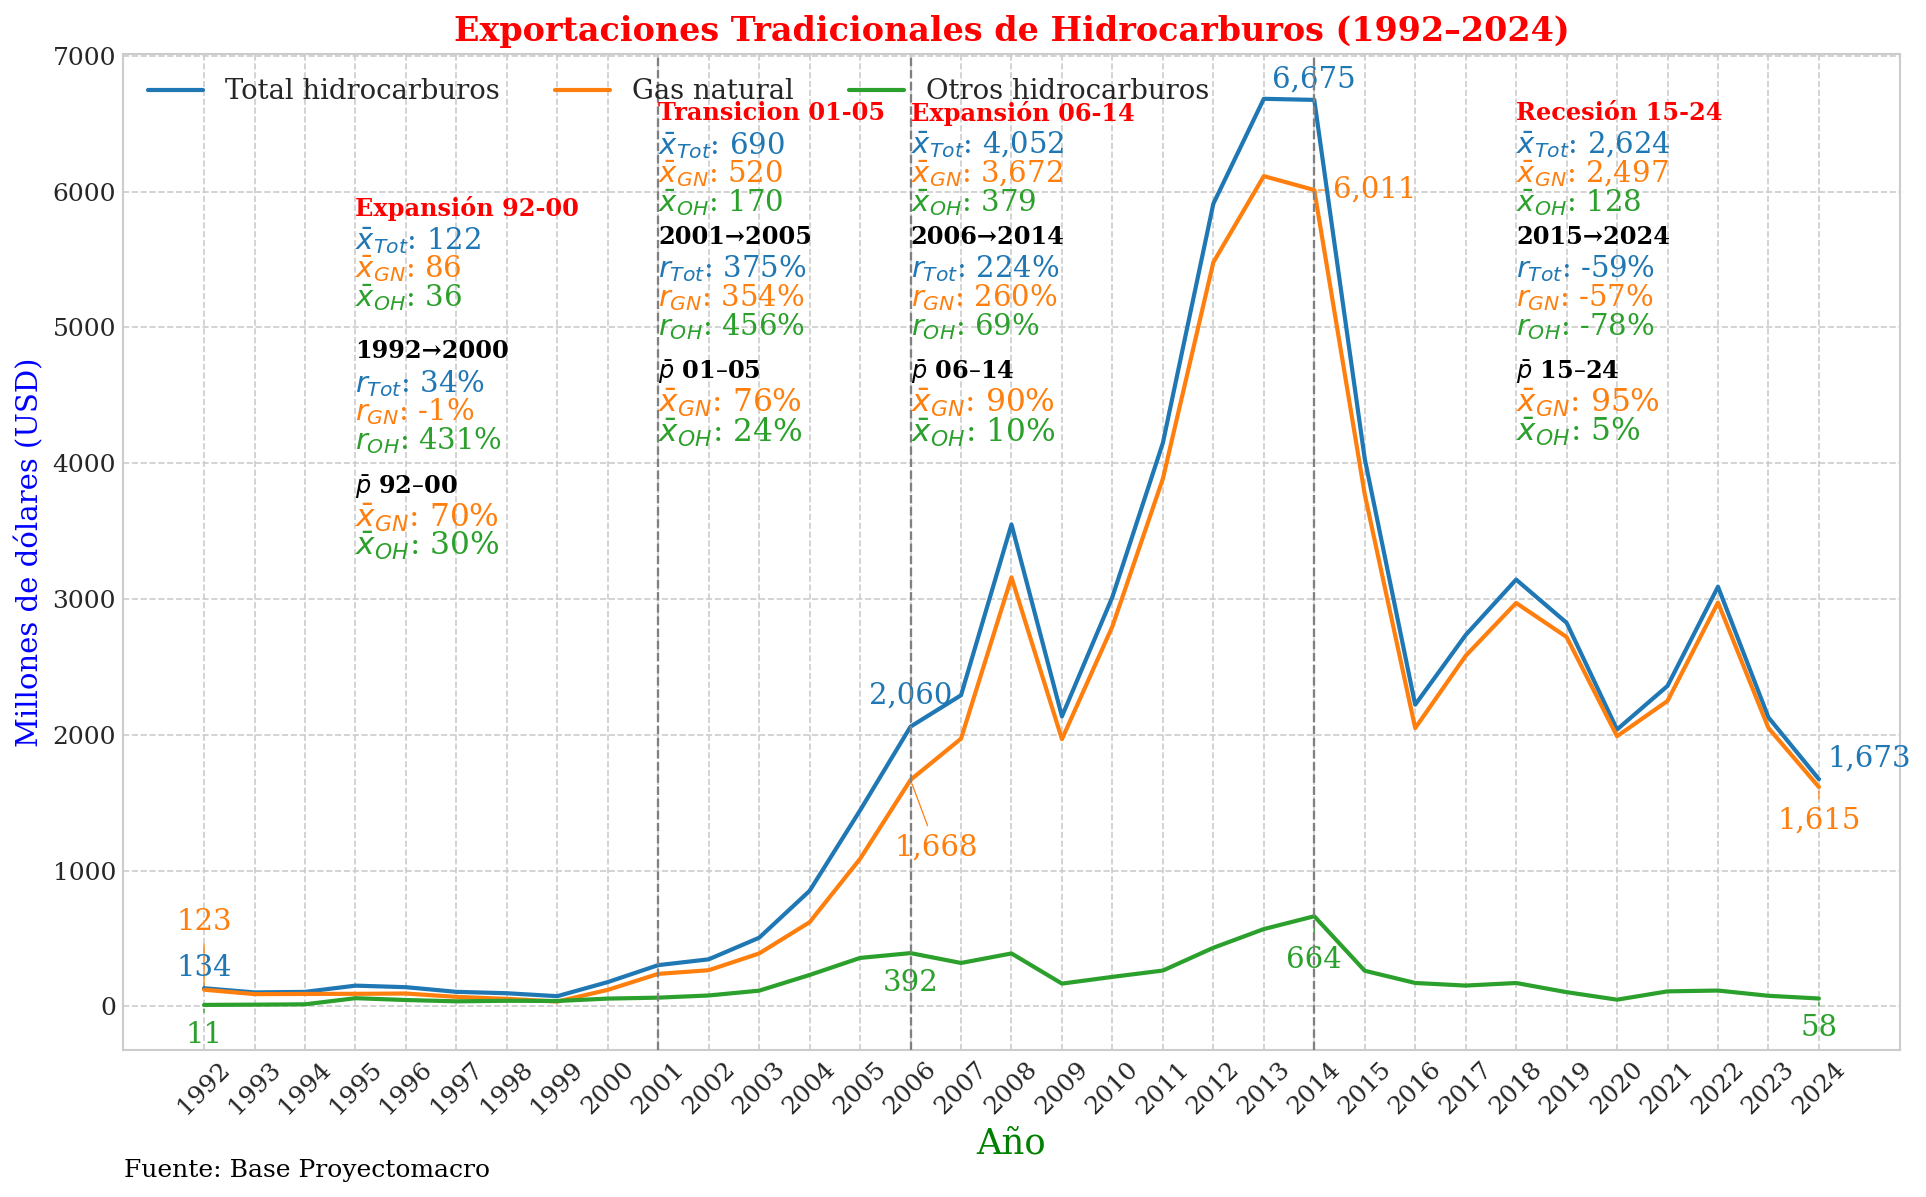

In [14]:
# ───────────────────────── 0. IMPORTS Y CONFIGURACIÓN GLOBAL ─────────────────────────
import os, sys, sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Ruta a utilidades propias
default_utils = os.path.abspath('../')
sys.path.append(default_utils)
from graficos_utils import *
from config import *          # CYCLES, hitos_v, annot_years, periodos_tasas ...

# Indicador y directorio de salida
INDICADOR   = "exportaciones"
OUTPUT_DIR  = f"../../../../assets/tesis/serie_completa/{INDICADOR}"
os.makedirs(OUTPUT_DIR, exist_ok=True)

set_style()  # aplica estilo global

# ───────────────────────────── 1. CARGA DE DATOS ─────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df = (
        pd.read_sql(
            "SELECT * FROM exportaciones_tradicionales_hidrocarburos",
            conn,
            index_col="año",
        )
        .sort_index()                 # 1992-2024, millones USD
    )

# ──────────────── 2. DEFINICIÓN DE SERIES, COLORES Y ABREVIATURAS ────────────────
series = [
    ("hidrocarburos",       "Total hidrocarburos"),
    ("gas_natural",         "Gas natural"),
    ("otros_hidrocarburos", "Otros hidrocarburos"),
]
cols_series = [col for col, _ in series]

cmap   = plt.get_cmap("tab10")
colors = {col: cmap(i) for i, (col, _) in enumerate(series)}
abbr   = {"hidrocarburos": "Tot", "gas_natural": "GN", "otros_hidrocarburos": "OH"}

# ──────────────── 3. PREPARACIÓN DE CICLOS, ANOTACIONES Y PERÍODOS ────────────────
cycles       = adjust_cycles(df, CYCLES)
annot_years  = adjust_annot_years(df, annot_years)
periodos     = adjust_periods(df, periodos_tasas)
cycle_stats  = {name: df.loc[slc].mean().to_dict() for name, slc in cycles.items()}

# ──────────────── 4. OFFSETS Y POSICIONAMIENTOS ────────────────
hitos_offsets = {año: 0.67 for año in hitos_v}

# 1) Anotaciones de valores por serie (sin cambios en años internos)
annotation_offsets = {
    "hidrocarburos": {
        1992: (0, 150), 2000: (0, 150), 2006: (0, 230),
        2008: (0, 150), 2014: (0, 150), 2018: (0, 150), 2024: (1, 150),
    },
    "gas_natural": {
        1992: (0, 500), 2000: (0, 500), 2006: (0.5, -500),
        2008: (0, -1000), 2014: (1.2, 0), 2018: (0, -500), 2024: (0, -250),
    },
    "otros_hidrocarburos": {
        1992: (0, -220), 2000: (0, -220), 2006: (0, -220),
        2008: (0, -220), 2014: (0, -320), 2018: (0, -220), 2024: (0, -220),
    },
}

# 2) Líneas verticales según hitos_v (se mantiene la comprensión)
hitos_offset = {a: 0.8 for a in hitos_v}  # keys de hitos_v según config.py :contentReference[oaicite:0]{index=0}

# 3) Posición de medias por ciclo (claves ajustadas a config.CYCLES)

medias_offsets = {
    "Expansión 92-00":    (1995, 0.85),   # antes "Expansión 92-99"
    "Transicion 01-05":   (2001, 0.95),   # antes "Crisis 00-05"
    "Expansión 06-14":    (2006, 0.95),   # antes "Expansión 06-13"
    "Recesión 15-24":     (2018, 0.95),   # antes "Recesión 14-24"
}

# 4) Tasas de crecimiento anotadas (claves según periodos_tasas)
tasas_offsets = {
    "1992-2000": (1995, 0.70),   # antes "1992-2000"
    "2001-2005": (2001, 0.82),   # antes "2000-2006"
    "2006-2014": (2006, 0.82),
    "2015-2024": (2018, 0.82),   # antes "2014-2024"
}

# 5) Participación promedio por periodo (mismas claves que arriba)
participation_offsets = {
    "1992-2000": (1995, 0.56),   # antes "1992-1999"
    "2001-2005": (2001, 0.68),   # antes "2000-2005"
    "2006-2014": (2006, 0.68),   # antes "2006-2013"
    "2015-2024": (2018, 0.68),   # antes "2014-2024"
}

# ───────────────────────────── 5. GENERACIÓN DE LA GRÁFICA ─────────────────────────────
fig, ax = init_base_plot(
    df=df,
    series=series,
    colors=colors,
    title=f"Exportaciones Tradicionales de Hidrocarburos ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    ylabel="Millones de dólares (USD)",
    source_text="Fuente: Base Proyectomacro",
)

# 5.1 Hitos verticales
add_hitos(ax, df.index, hitos_v, hitos_offsets)

# 5.2 Medias de ciclo
add_cycle_means_multi(
    ax,
    cycle_stats,
    medias_offsets,
    abbr,
    colors,
    line_spacing=ax.get_ylim()[1] * 0.03,
)

# 5.3 Anotaciones de valores puntuales
add_year_value_annotations(
    ax,
    df,
    annot_years,
    cols_series,
    annotation_offsets,
    colors,
    arrow_lw=0.6,
)

# 5.4 Tasas de crecimiento entre periodos
add_period_growth_annotations_multi(
    ax,
    df,
    periodos,
    cols_series,
    tasas_offsets,
    colors,
    abbr,
)

# 5.5 Cuadros de participación media
components              = ["gas_natural", "otros_hidrocarburos"]
total_col               = "hidrocarburos"

add_participation_cycle_boxes(
    ax,
    df,
    periodos,
    components,
    total_col,
    participation_offsets,
    abbr_map=abbr,
    colors={c: colors[c] for c in components},
)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "exportaciones_tradicionales_hidrocarburos.png"), dpi=300)
plt.show()


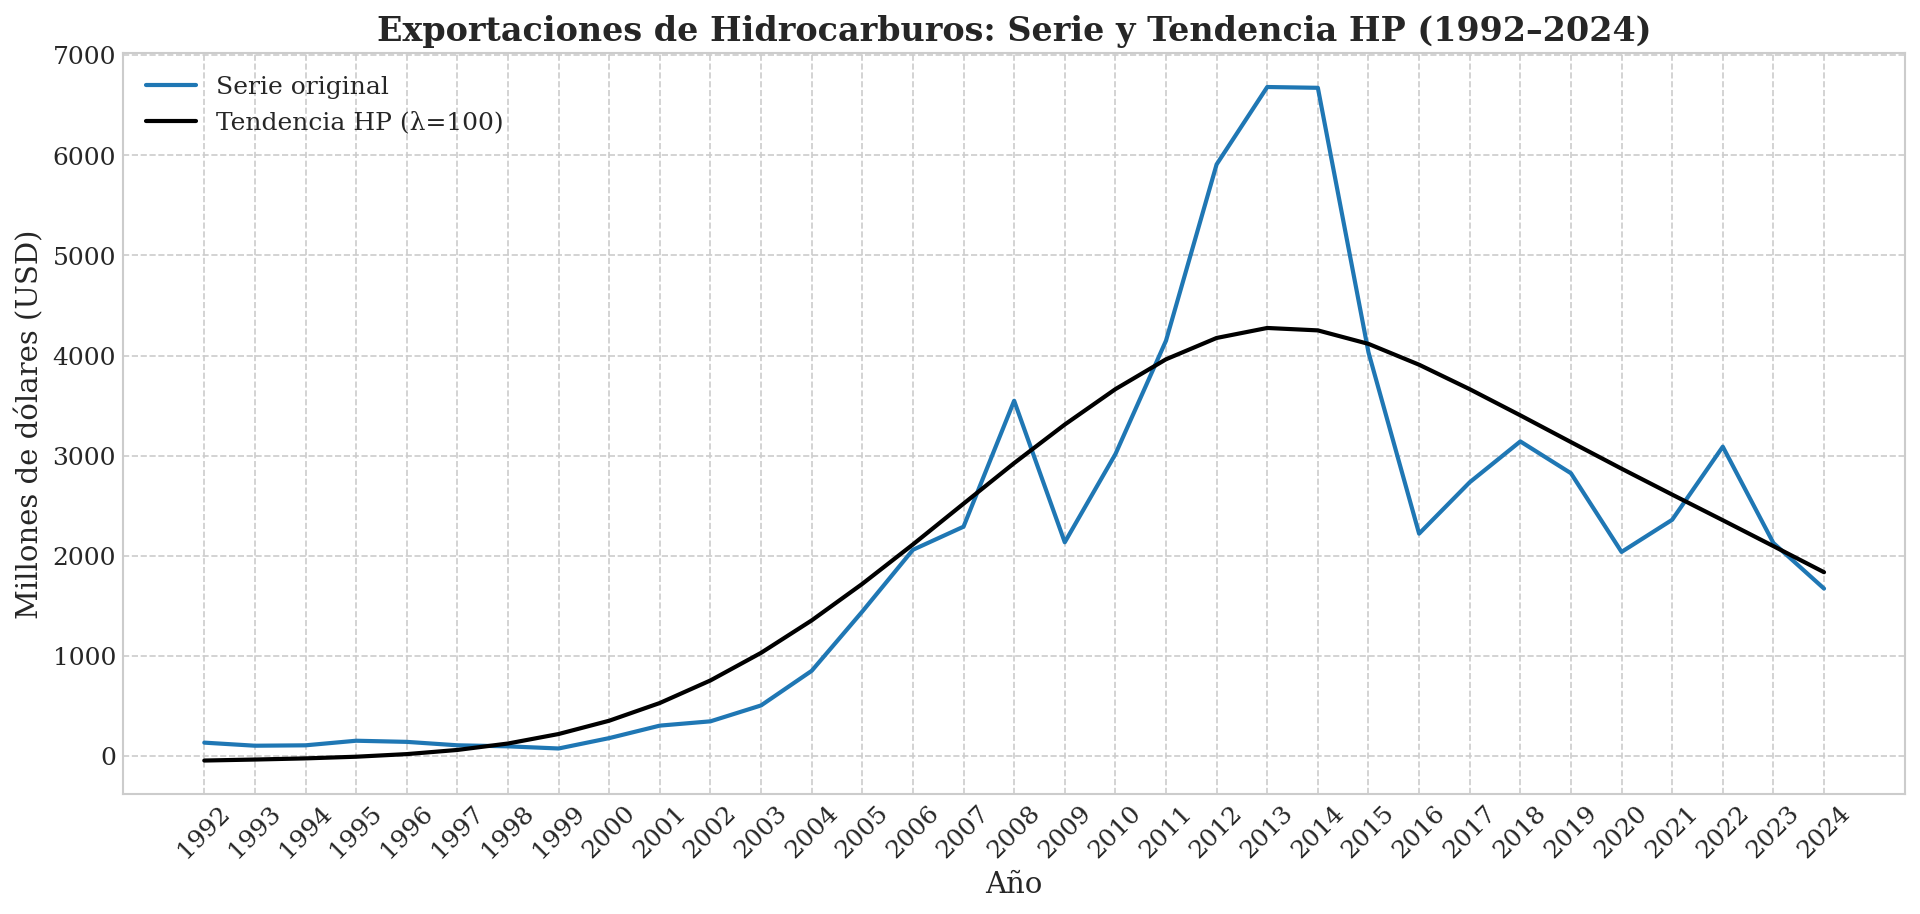

In [ ]:
# ── 2.b Filtro Hodrick–Prescott ─────────────────────────────────────
from statsmodels.tsa.filters.hp_filter import hpfilter

λ_HP = 100              # anual
# Aplicamos HP al total y añadimos columnas al DataFrame
df['ciclo_hp'], df['tendencia_hp'] = hpfilter(df['hidrocarburos'], lamb=λ_HP)

# ── 2.c Visualización rápida ────────────────────────────────────────
fig_hp, ax_hp = plt.subplots(figsize=(13, 6))
ax_hp.plot(df.index, df['hidrocarburos'], color=cmap(0), label='Serie original')
ax_hp.plot(df.index, df['tendencia_hp'], color='black', linewidth=2,
           label='Tendencia HP (λ=100)')

ax_hp.set_title("Exportaciones de Hidrocarburos: Serie y Tendencia HP (1992–2024)",
                fontweight='bold')
ax_hp.set_xlabel("Año")
ax_hp.set_ylabel("Millones de dólares (USD)")
ax_hp.legend(loc='upper left')
plt.tight_layout()
ax_hp.set_xticks(df.index[::max(1,len(df)//31)])
ax_hp.tick_params(axis="x", rotation=45)
plt.show()
plt.close(fig_hp)